In [1]:
print("First Name: Tang")
print("Sure Name: Zhirui")
print("Matriculation number: 1942800")
print("E-mail: 1942800@uni-wuppertal.de")
print("Degree Type: Master") # Bachelor or Master
print("Degree Name: Master of Science in Computer Simulation in Science") # E.g. Master of Science in Computer Simulation in Science

First Name: Tang
Sure Name: Zhirui
Matriculation number: 1942800
E-mail: 1942800@uni-wuppertal.de
Degree Type: Master
Degree Name: Master of Science in Computer Simulation in Science


## Import all necessary modules

In [2]:
import math
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import interp1d
from prettytable import PrettyTable

# Import here if more libraries are necessary

## Test Parameters

In [3]:
# Input parameters
sigma = 0.3
K = 10
S_min = 3
S_max = 30
r = 0.05
T = 1

In [4]:
def ADE(M, N, r, sigma, S_max, S_min, K, T):
    delta_x = (S_max - S_min) / M
    delta_t = T / N
    V       = np.zeros((N+1, M+1))

    
    #boundary condition
    V[:, 0] = 0
    for i in range(0, N+1):
        V[i, M] = S_max - K*np.exp(-r*(i*delta_t)) #tao = T - t
                                                   #np.fliplr() at the end
    #initial condition
    for j in range(0, M+1):
        V[0, j] = np.maximum((S_min+j*delta_x) - K, 0) 
                                      
    V_hat   = V
    V_tilde = V
    
    for i in range(0, N):
        #calculate V_hat
        for j in range(1, M):
            a = 0.5*sigma**2*(S_min+j*delta_x)**2*delta_t / delta_x**2
            b = r*(S_min+j*delta_x)*delta_t / (2*delta_x)
            c = r/2*delta_t
            V_hat[i+1, j]   = - ((a-b)*V_hat[i+1,j-1]  \
                              + (a+b)*V_hat[i,  j+1]   \
                              + (1-a-b-c)*V_hat[i,  j] ) \
                              / (-1-a+b-c)
        #calculate V_tilde    
        for j in range(M-1, 0, -1):
            a = 0.5*sigma**2*(S_min+j*delta_x)**2*delta_t / delta_x**2
            b = r*(S_min+j*delta_x)*delta_t / (2*delta_x)
            c = r/2*delta_t
            V_tilde[i+1, j] = - ((a+b)*V_tilde[i+1,j+1] \
                              + (1-a+b-c)*V_tilde[i, j]  \
                              + (a-b)*V_tilde[i, j-1] ) \
                              / (-1-a-b-c) 
    
    V = np.flipud(0.5*(V_hat + V_tilde))
    
    return V

## Define a function that return the exact solution for an European Call option

In [5]:
def BS_exact(sigma, r, K, S0, T):
    """
      Function that return the exact solution for an European Call option

      Input:  sigma -> Stock volatility
              r     -> Market interest rate 
              S0    -> Stock price today
              T     -> Contract maturity

      Output: V     -> European call option value at t=0

    """
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T));
    d2 = d1 - sigma*np.sqrt(T);
    V = S0 * norm.cdf(d1,0,1) - K * np.exp(-r*T) * norm.cdf(d2,0,1);
    return V

If there is no bug in this code, ADE may be not so accurate

We need to analyze the convergence condition and the order

+------+-----+--------------------+-------------------+-----------------------+
|  N   |  M  |       V_ex         |       V_app       |        error_V        |
+------+-----+--------------------+-------------------+-----------------------+
|  3   |  5  | 2.8880430932111443 | 3.229466039955216 |   0.3414229467440717  |
|  50  |  20 | 2.8880430932111443 | 2.894443026198072 |  0.006399932986927759 |
| 200  |  40 | 2.8880430932111443 | 2.889950812797076 |  0.001907719585931833 |
| 800  |  80 | 2.8880430932111443 | 2.887654490396386 | 0.0003886028147581655 |
| 3200 | 160 | 2.8880430932111443 | 2.887714002525305 | 0.0003290906858390841 |
+------+-----+--------------------+-------------------+-----------------------+


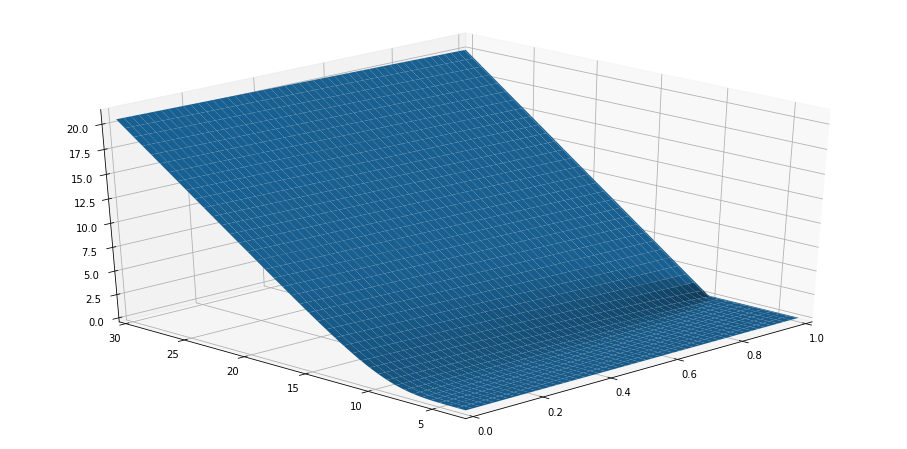

In [7]:
S0 = 12
N = [3, 50, 200, 800, 3200];
M = [5, 20, 40, 80, 160];

V_ex = BS_exact(sigma, r, K, S0, T)
V_app = np.zeros(len(N))
error_V = np.zeros(len(N))

x = PrettyTable()

for i in range(len(N)):
    V = ADE(M[i], N[i], r, sigma, S_max, S_min, K, T)
    s = np.linspace(S_min, S_max, M[i]+1)
    t = np.linspace(0, T, N[i]+1)

    y = interp1d(s, V[0, :]) 
    V_app[i] = y(S0)
    error_V[i] = abs(V_app[i] - V_ex)
    x.add_row([N[i], M[i], V_ex, V_app[i], error_V[i]])
    
print("If there is no bug in this code, ADE may be not so accurate\n")
print("We need to analyze the convergence condition and the order\n")
x.field_names = ["N", "M", "V_ex ", "V_app", "error_V"]    
print(x)



hf = plt.figure(figsize=(16, 8))
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(t, s)
ha.plot_surface(X, Y, V.transpose())
ha.view_init(30, -135)
ha.set_xlim([0,1])
ha.set_ylim([3,30])
ha.set_zlim([0,21]) #[0, S_max-0.9K]
plt.show()

